# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Описание данных
* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

План работы:
1. Первое знакомство с данными, с которыми предстоит работать.
2. Подготовка данных к дальнейшему анализу:
    * Работа с пропусками
    * Работа с дубликатами
3. Добавление новых столбцов.
4. Анализ данных и ответ на следующие вопросы:
    * Какие продажи можно считать быстрыми?
    * Какие продажи можно считать аномально долгими?
    * Какие параметры больше всего влияют на полную стоимость квартиры?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


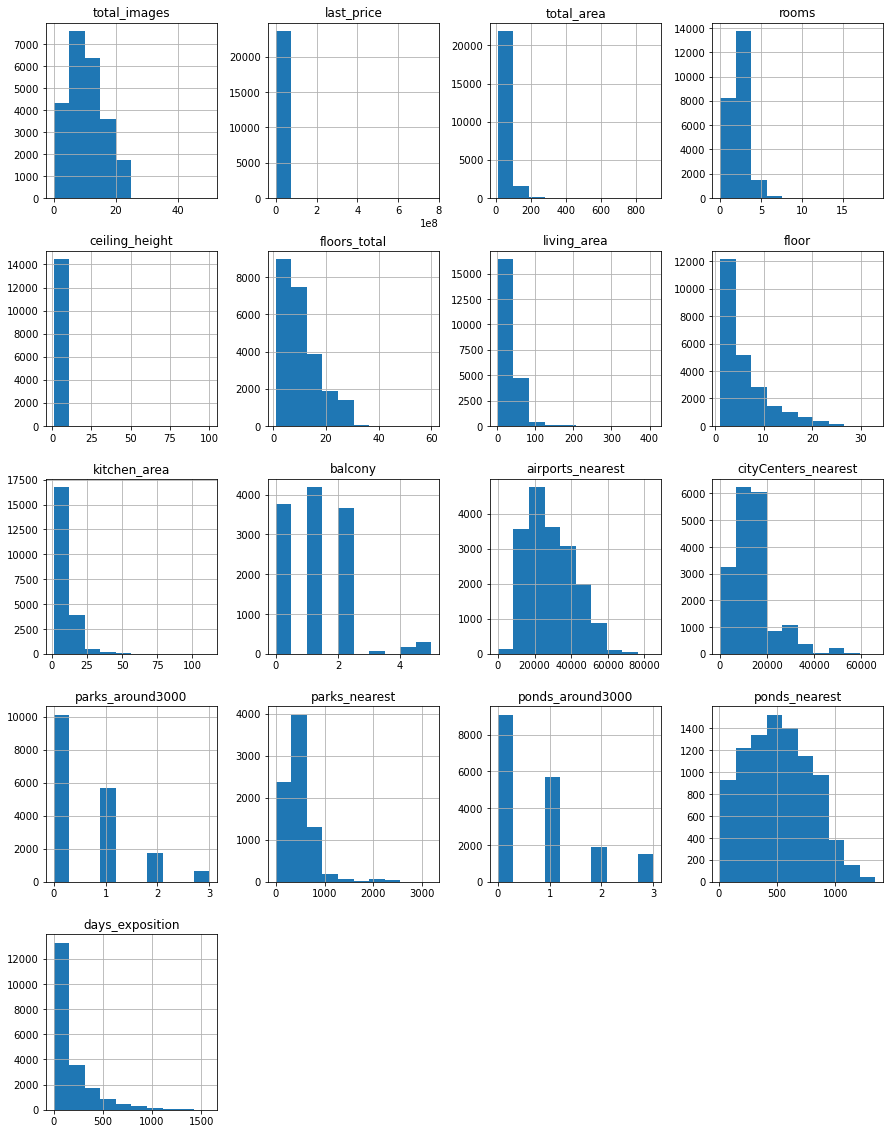

In [5]:
data.hist(figsize=(15,20))
plt.show()

Исходя из выводов выше сразу можно сказать, что во многих столбцах есть пропуски. Скорее всего есть проблемы с типами данных в некоторых столбцах. В некоторых столбцах есть значения, заметно отличающиеся от остальных. В таком виде данные не готовы к дальнейшему анализу.

### Предобработка данных

На этапе предобработки данных выполним следующие шаги:
* По возможности избавимся от пропущенных значений.
* Приведём данные в столбцах к правильным типам, если это необходимо.
* Устраним дубликаты.

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Обнаружены пропуски в следующих столбцах: `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition`.

Сразу заметим неправильное именование столбца `cityCenters_nearest` (одновременно используются "snake_case" и "camelCase"). Исправим это.

In [7]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Заполним пропуски в столбцах `balcony` и `is_apartment` нулями. Вероятно, причина их появления в `balcony` - отсутствие балконов в соответствующих квартирах. Для `is_apartment` причина может быть в том, что квартиры не являются апартаментами.

In [8]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(0)

Пропуски в столбце `locality_name` можно удалить без потерь в данных, так как их число очень мало (всего 49).

In [9]:
data = data.dropna(subset=['locality_name'])

In [10]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest     5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

In [11]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Заметим, что столбцы `is_apartment` и `first_day_exposition` имеет неверные типы.<br>
Приведём `is_apartment` к типу `bool`, а `first_day_exposition` к типу `datetime`

In [12]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

In [13]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [14]:
data.duplicated().sum()

0

Явные дубликаты в данных отсутствуют.

In [15]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В списке уникальных значений столбца с названиями населённых пунктов "посёлок" и "поселок" - неявные дубликаты, отличающиеся одной буквой. Заменим второй вариант на первый.

In [16]:
data['locality_name'] = (
     data['locality_name']
     .str
     .replace('поселок', 'посёлок')
)

data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет

На этапе предобработки мы поработали с пропусками в данных, дубликатами и исправили нэйминг столбцов.<br>

Пропуски были обнаружены в 14 столбцах: `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition`.

* `ceiling_height` - причиной пропуска вполне может быть то, что данное поле не является обязательным при создании объявления
* `floors_total` - на мой взгляд, причина пропуска схожа с предыдущим столбцом или же человек выставил на продажу частный дом, поэтому не указал число этажей
* `living_area` - создатель обьявления мог посчитать эту информацию неважной и не указать её
* `is_apartment` - скорее всего, пропуск в этом поле свидетельствует о том, что квартира не является апартаментами
* `kitchen_area` - если квартира является студией, то у нее нет отдельной кухни. Поэтому пропуски могли появиться по причине того, что квартира является студией или же причина схожа с `living_area`
* `balcony` - пропуски в этом поле свидетельствуют о том, что в квартире нет балкона
* `locality_name` - возможно пропущенных населённых пунктов не было в списке или люди просто забыли их указать. В подтверждение второго варианта можно отметить относительно небольшее количество пропусков в этом столбце
* `airports_nearest` - вероятно причиной пропусков является отсутствие аэропорта вблизи населённого пункта
* `city_centers_nearest` - скорее всего причина в том, что информацию посчитали неважной, поскольку в каждом населённом пункте можно выделить центр
* `parks_around3000` - причина схожа с `airports_nearest`
* `parks_nearest` - причина схожа с `airports_nearest`
* `ponds_around3000` - причина схожа с `airports_nearest`
* `ponds_nearest` - причина схожа с `airports_nearest`
* `days_exposition` - причина может быть в том, что объявления после продажи не закрыли и они до сих пор активны

В столбцах `is_apartment` и `balcony` пропущенные значения заменены на 0.
Пропуски в столбце `locality_name` заменены на ключевое слово "Неизвестен".

В данных не было обнаружено явных дубликатов, но была обнаружена и исправлена одна пара неявных (различия в написании слова посёлок).

Была обнаружена ошибка в нэйминге столбца `cityCenters_nearest`. Столбец переименован в `city_centers_nearest`.

Данные готовы к дальнейшему анализу.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу столбец содержащий цену одного квадратного метра.

In [17]:
data['square_meter_price'] = (data['last_price'] / data['total_area']).round(2)
data['square_meter_price'].head()

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: square_meter_price, dtype: float64

Добавим столбец с днём недели, в который была совершена публикации.<br>
Каждому дню недели будет соответствовать целое число следующим образом: понедельник - 0, вторник - 1 и т.д.

In [18]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.dayofweek
data['day_of_week_exposition'].head()

0    3
1    1
2    3
3    4
4    1
Name: day_of_week_exposition, dtype: int64

Добавим столбцы с месяцем публикации и годом публикации.

In [19]:
data['month_of_exposition'] = data['first_day_exposition'].dt.month_name()
data['year_of_exposition'] = data['first_day_exposition'].dt.year

display(data['month_of_exposition'].head())
data['year_of_exposition'].head()

0       March
1    December
2      August
3        July
4        June
Name: month_of_exposition, dtype: object

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_of_exposition, dtype: int64

Добавим столбец с типом этажа (значения — «первый», «последний», «другой»).

In [20]:
def get_floor_type(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    return 'Другой'

data['floor_type'] = data.apply(get_floor_type, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_of_week_exposition,month_of_exposition,year_of_exposition,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.37,3,March,2019,Другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.79,1,December,2018,Первый
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.71,3,August,2015,Другой
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.10,4,July,2015,Другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.00,1,June,2018,Другой


Наконец, добавим столбец, содержащий расстояние до центра города в километрах.

In [21]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_of_week_exposition,month_of_exposition,year_of_exposition,floor_type,city_centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,March,2019,Другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,December,2018,Первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,August,2015,Другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,July,2015,Другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,June,2018,Другой,8.0


Логично будет переименовать столбец `city_centers_nearest`, добавив к названию '_m'. 

In [22]:
data = data.rename(columns={'city_centers_nearest' : 'city_centers_nearest_m'})
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest_m',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'square_meter_price',
       'day_of_week_exposition', 'month_of_exposition', 'year_of_exposition',
       'floor_type', 'city_centers_nearest_km'],
      dtype='object')

На данном этапе мы добавили в таблицу несколько новых столбцов:
1. `square_meter_price` - цена одного квадратного метра
2. `day_of_week_exposition` - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
3. `month_of_exposition` - месяц публикации объявления
4. `year_of_exposition` - год публикации объявления
5. `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»)
6. `city_centers_nearest_km` - расстояние до центра города в километрах

А также переименовали столбец `city_centers_nearest` в `city_centers_nearest_m` для того чтобы было понятно различие со столбцом `city_centers_nearest_km`.

### Проведите исследовательский анализ данных

Перед анализом зафиксируем исходный размер выборки.

In [23]:
num_of_objects_before = data.shape[0]
num_of_objects_before

23650

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

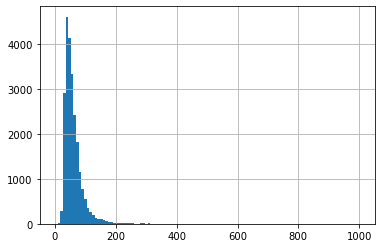

In [24]:
data['total_area'].hist(bins=115, range=(0, 1000))
data['total_area'].describe()

Гистограмма выглядет вполне нормально. Ожидаемый результат для гистограммы нормального распределения.<br>
Большого количества выбросов нет.<br>

Минимальное значение общей площади составляет `12` квадратных метров.<br>
Среднее - `60`.<br>
Максимальное - `900`.

count    21752.000000
mean        34.448356
std         22.037664
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

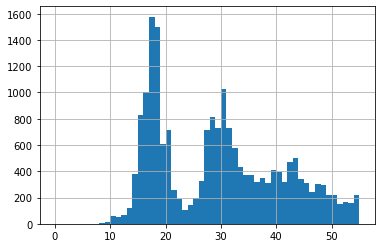

In [25]:
data['living_area'].hist(bins=55, range=(0, 55))
data['living_area'].describe()

Исходя из гистограммы видно, что распределение имеет два пика. Оно не является ни нормальным, ни распределением Пуасонна. Странным является большое количество значений в промежутке `2` до `22`. Вполне возможно, что это студии, поскольку размер подозрительно маленький для обычной квартиры. Необходимо это проверить. В противном случае, увеличим эти значения в `10` раз, возможно, продавцы ошиблись указав площадь, в `10` раз меньшую искомой.

In [26]:
data.query('living_area >= 10 & living_area <= 22')['studio'].value_counts()

False    7155
True      119
Name: studio, dtype: int64

Гипотеза не подтвердилась.

count    21752.000000
mean        86.837500
std         65.465091
min         20.000000
25%         32.900000
50%         47.800000
75%        160.000000
max        409.700000
Name: living_area, dtype: float64

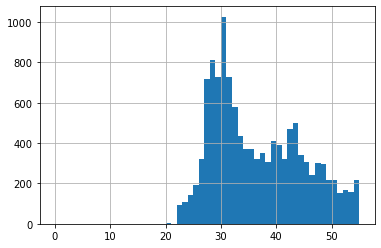

In [27]:
data.loc[(data['living_area'] >= 2) & (data['living_area'] <= 22), 'living_area'] = data['living_area'] * 10
data['living_area'].hist(bins=55, range=(0, 55))
data['living_area'].describe()

Теперь распределение имеет более привычный вид и напоминает нормальное. В промежутке от `40` до `50` можем заметить локальный пик, но он объясним тем, что на рынке относительно много квартир с соответствующей жилой площадью.

Минимальное значение жилой площади составляет `20` квадратных метров.<br>
Среднее - `86`.<br>
Максимальное - `409`.

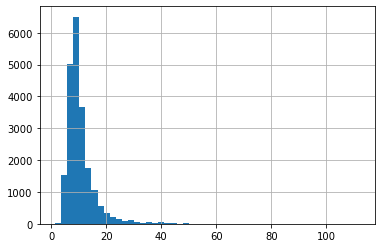

count    21381.000000
mean        10.566403
std          5.901753
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

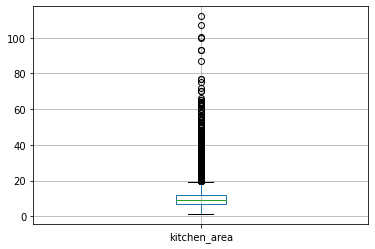

In [28]:
data['kitchen_area'].hist(bins=50)
plt.show()
data.boxplot('kitchen_area')
data['kitchen_area'].describe()

В данных присутствуют квартиры с площадью кухни выше, чем `80 квадратных метров`. Скорее всего, такая большая площадь кухни обусловлена большой общей площадью квартиры. Проверим это.

In [29]:
data.query('kitchen_area > 80')['total_area'].describe()

count      7.000000
mean     357.100000
std      282.428115
min      146.000000
25%      179.500000
50%      249.700000
75%      422.500000
max      900.000000
Name: total_area, dtype: float64

Как мы видим, действительно, средняя площадь квартиры среди этой выборки - `357.1` квадратных метров, что достаточно много. Следовательно, данные в столбце `kitchen_area` не требуют изменений, причина выбросов установлена.

Минимальное значение площади кухни составляет `1.3` квадратных метра.<br>
Среднее - `11`.<br>
Максимальное - `112`.

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

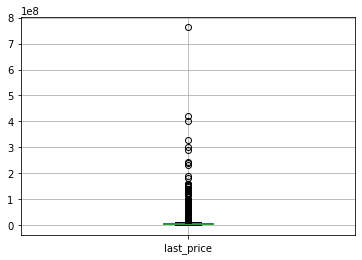

In [30]:
data.boxplot('last_price')
data['last_price'].describe()

На графике видно большое количество квартир с относительно высокой стоимостью, но есть небольшое число квартира, чья стоимость значительно отличается от остальных. Это квартиры со стоимостью, выше чем `2 * 10^8`. Уберем выбросы и построим гистограмму.

count    2.364100e+04
mean     6.407475e+06
std      7.902979e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.647000e+06
75%      6.790000e+06
max      1.908700e+08
Name: last_price, dtype: float64

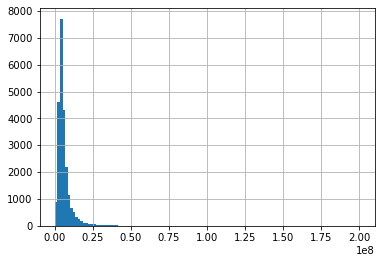

In [31]:
data = data.query('last_price < 2e8')
data['last_price'].hist(bins=120, range=(0, 2e8))
data['last_price'].describe()

Теперь распределение напоминает нормальное распределение.

Минимальное значение цены составляет `1.2 * 10^4`.<br>
Среднее - `6.4 * 10^6`.<br>
Максимальное - `1.9 * 10^8`.

count    23641.000000
mean         2.068610
std          1.074837
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

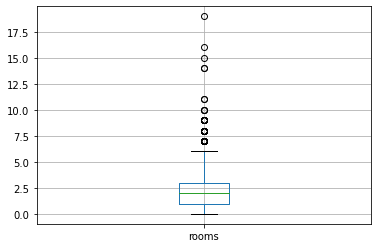

In [32]:
data.boxplot('rooms')
data['rooms'].describe()

Заметим выбросы - это квартиры с числом комнат выше `10` и меньше `1`. Избавимся от них и построим гистограмму.

count    23437.000000
mean         2.082348
std          1.040465
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: rooms, dtype: float64

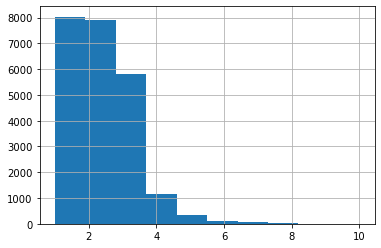

In [33]:
data = data.query('rooms <= 10 & rooms >= 1')
data['rooms'].hist(bins=10)
data['rooms'].describe()

Минимальное количество комнат - `1`.<br>
Среднее - `2`.<br>
Максимальное - `10`.

count    14397.000000
mean         2.768986
std          1.249011
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

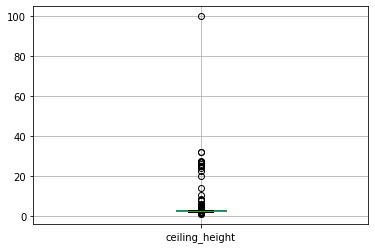

In [34]:
data.boxplot('ceiling_height')
data['ceiling_height'].describe()

На графике видны выбросы, избавимся от них, положив, что валидные значения находятся в пределах размаха "усов". Также обратим внимание на значения `>=20`. Вероятно, продавец имел в виду значения, в десять раз меньшие указанных. Учтём это и исправим.

In [35]:
q1, q3 = data['ceiling_height'].quantile(0.25), data['ceiling_height'].quantile(0.75)
iqr = q3 - q1
print(f'Межквартиальных размах равен {round(iqr, 2)}')
abnormal_low = q1 - 1.5 * iqr
print(f'Аномально низкие значения находятся ниже {round(abnormal_low, 2)}')
abnormal_high = q3 + 1.5 * iqr
print(f'Аномально высокие значения находятся выше {round(abnormal_high, 2)}')

Межквартиальных размах равен 0.29
Аномально низкие значения находятся ниже 2.07
Аномально высокие значения находятся выше 3.24


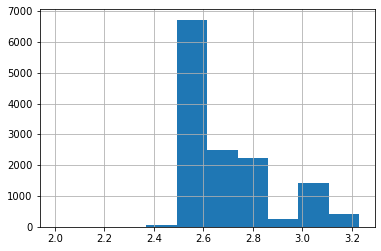

count    13613.000000
mean         2.679641
std          0.184745
min          2.000000
25%          2.500000
50%          2.630000
75%          2.760000
max          3.230000
Name: ceiling_height, dtype: float64

In [36]:
data = data.query('(ceiling_height >= @abnormal_low and ceiling_height <= @abnormal_high) or (ceiling_height >= 20 and ceiling_height < 40) or ceiling_height.isna()')
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 10
data['ceiling_height'].hist(bins=10)
plt.show()
data['ceiling_height'].describe()

Минимальное значение высоты потолка составляет `2` метра.<br>
Среднее - `2.7`.<br>
Максимальное - `3.2`.

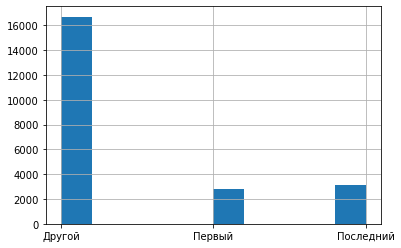

In [37]:
data['floor_type'].hist()
plt.show()

С этим столбцом проблем нет. Ожидаемо, что наибольшее количество значений равно "Другой".

count    22571.000000
mean        10.795889
std          6.592932
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

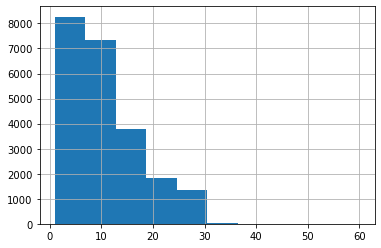

In [38]:
data['floors_total'].hist()
data['floors_total'].describe()

Данные выглядят нормально.

Минимальное количество этажей - `1`.<br>
Среднее - `12`.<br>
Максимальное - `52`.

count    17259.000000
mean     14566.565792
std       8507.158410
min        318.000000
25%       9923.500000
50%      13296.000000
75%      16462.500000
max      65968.000000
Name: city_centers_nearest_m, dtype: float64

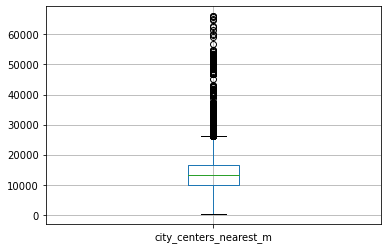

In [39]:
data.boxplot('city_centers_nearest_m')
data['city_centers_nearest_m'].describe()

Избавимся от выбросов которые лежат, выше чем размаха верхнего "уса".

In [40]:
q1, q3 = data['city_centers_nearest_m'].quantile(0.25), data['city_centers_nearest_m'].quantile(0.75)
iqr = q3 - q1
print(f'Межквартиальный размах равен {iqr}')
abnormal_high = q3 + 1.5 * iqr
print(f'Верхняя граница размаха равна {abnormal_high}')

Межквартиальный размах равен 6539.0
Верхняя граница размаха равна 26271.0


count    15493.000000
mean     12305.017492
std       4903.786304
min        318.000000
25%       9304.000000
50%      12689.000000
75%      15426.000000
max      26239.000000
Name: city_centers_nearest_m, dtype: float64

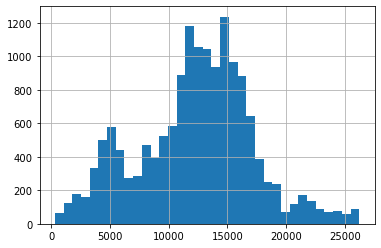

In [41]:
data = data.query('city_centers_nearest_m < @abnormal_high or city_centers_nearest_m.isna()')
data['city_centers_nearest_m'].hist(bins=35)
data['city_centers_nearest_m'].describe()

Минимальное расстояние до центра составляет `318` метр.<br>
Среднее - `12168br>
Максимальное - `24568`.

count    7585.000000
mean      528.580488
std       278.948086
min        13.000000
25%       306.000000
50%       515.000000
75%       747.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

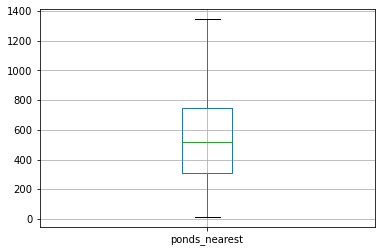

In [42]:
data.boxplot('ponds_nearest')
data['ponds_nearest'].describe()

Данные в столбце `ponds_nearest` в порядке. Можно строить гистограмму.

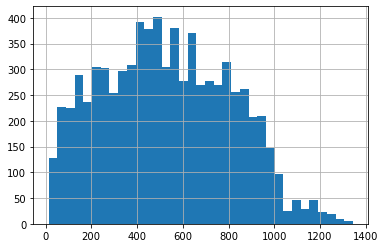

In [43]:
data['ponds_nearest'].hist(bins=35)
plt.show()

Минимальное расстояние до парка составляет `13` метров.<br>
Среднее - `528`.<br>
Максимальное - `1344`.

Проверим, какой процент данных мы потеряли, в результате преобразований выше.

In [44]:
num_of_objects_after = data.shape[0]
print(f'Оставшаяся доля данных после фильтрации {num_of_objects_after / num_of_objects_before:.2%}')

Оставшаяся доля данных после фильтрации 88.32%


Изучим, как быстро продавались квартиры.
Опишем, сколько времени обычно занимает продажа. 
Определим какие продажи можно считать быстрыми, а какие — необычно долгими.

count    18119.000000
mean       177.445499
std        216.744982
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

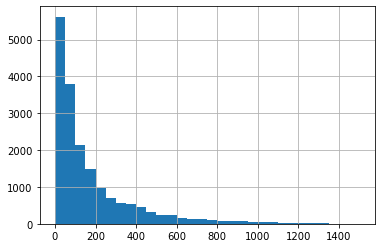

In [45]:
data['days_exposition'].hist(bins=30, range=(0, 1500))
data['days_exposition'].describe()

Распределение по столбцу `days_exposition` является распределением Пуасонна.

In [46]:
print(f"Среднее время продажи квартиры: {data['days_exposition'].mean()}")
print(f"Медианное время продажи квартиры: {data['days_exposition'].median()}")

Среднее время продажи квартиры: 177.44549919973508
Медианное время продажи квартиры: 93.0


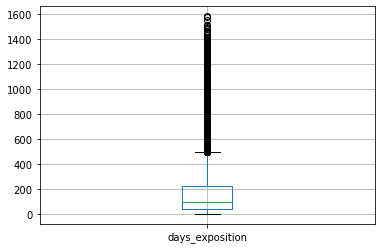

count    18119.000000
mean       177.445499
std        216.744982
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [47]:
data.boxplot('days_exposition')
plt.show()
data['days_exposition'].describe()

In [48]:
q3, q1 = data['days_exposition'].quantile(0.75), data['days_exposition'].quantile(0.25)
iqr = q3 - q1
print(f'Межквартиальный размах равен {iqr}')
print(f'Аномально высокие значения начинаются с {int(q3 + 1.5 * iqr)}')

Межквартиальный размах равен 180.0
Аномально высокие значения начинаются с 494


Исходя из диаграммы размаха и вычисленного значения межквартиального размаха делаем вывод, что слишком долгими можно считать продажи, совершённые более чем за `494` дня. Аномально быстрыми продажами можно считать продажи, совершённые менее чем за `44` дня.

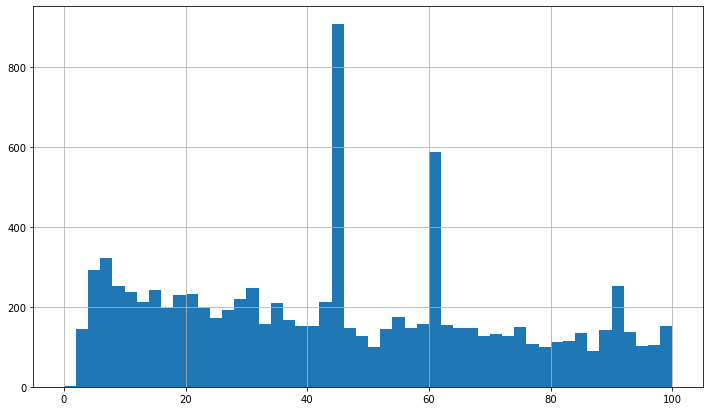

In [49]:
# Код ревьюера
data['days_exposition'].hist(bins=50, range=(0,100), figsize=(12, 7))
plt.show()

Узнаем, какие факторы больше всего влияют на полную стоимость объекта.
Изучим, зависит ли цена от:
* общей площади;
* жилой площади;
* площади кухни;
* количества комнат;
* этажа, на котором расположена квартира (первый, последний, другой);
* даты размещения (день недели, месяц, год)

Для начала посчитаем коэффиценты корреляции столбца, содержащего полные стоимости с другими столбцами.

In [50]:
print(f"Коэффицент корреляции стоимости и общей площади: {data['last_price'].corr(data['total_area']).round(2)}")
print(f"Коэффицент корреляции стоимости и жилой площади: {data['last_price'].corr(data['living_area']).round(2)}")
print(f"Коэффицент корреляции стоимости и площади кухни: {data['last_price'].corr(data['kitchen_area']).round(2)}")
print(f"Коэффицент корреляции стоимости и количества комнат: {data['last_price'].corr(data['rooms']).round(2)}")

Коэффицент корреляции стоимости и общей площади: 0.73
Коэффицент корреляции стоимости и жилой площади: -0.1
Коэффицент корреляции стоимости и площади кухни: 0.55
Коэффицент корреляции стоимости и количества комнат: 0.42


Для столбцов `day_of_week_exposition`, `month_of_exposition`, `year_of_exposition` и `floor_type` коэффиценты посчитать нельзя из-за нечисловых типов данных.

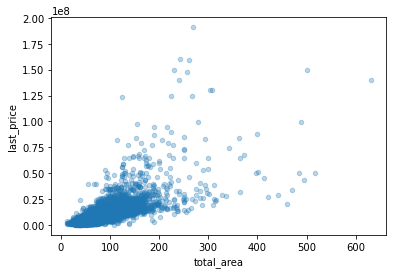

In [51]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()

По графику можем наблюдать следующую тенденцию: с ростом площади растёт стоимость квартиры (прямая пропорциональность). Об этом также свидетельствует довольно высокий соответствующий коэффицент корреляции.

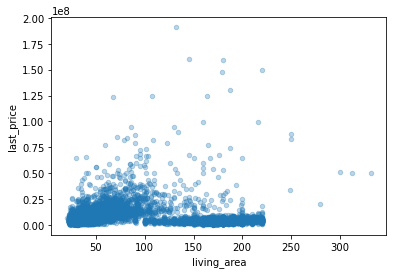

In [52]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()

Ситуация идентична с `total_area`.

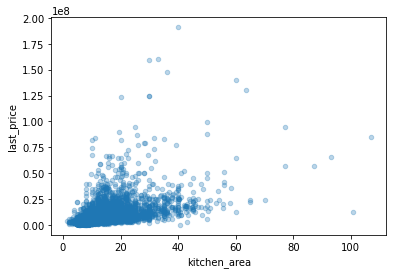

In [53]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3)
plt.show()

Можно сказать, что площадь кухни не влияет на стоимость квартиры.

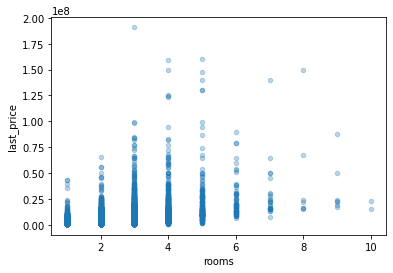

In [54]:
data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.3)
plt.show()

Количество комнат прямо пропорционально влияет на общую стоимость, но вклад этого параметра меньше, чем вклад жилой и общей площади.<br>

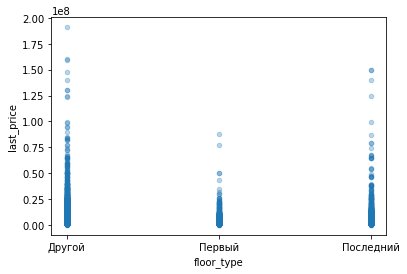

floor_type
Другой       6.407563e+06
Первый       4.588639e+06
Последний    6.124711e+06
Name: last_price, dtype: float64

In [55]:
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.3)
plt.show()
data.groupby('floor_type')['last_price'].mean()

Исходя из графика и дополнительной таблицы можно сделать следующий вывод: наибольшую среднюю цену имеют квартиры с типом этажа "Другой", затем идут квартиры на последнем этаже. Наименьшую среднюю цену имеют квартиры на первом этаже, их цена значительно меньше других.

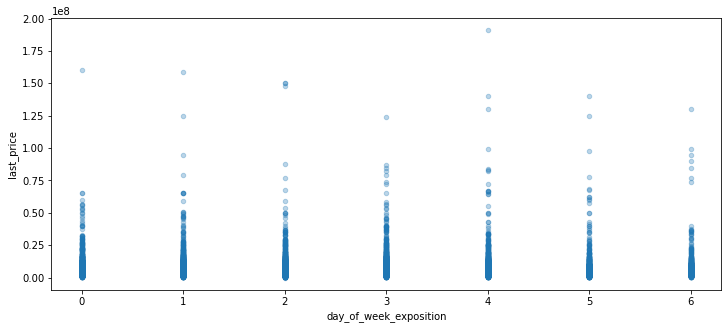

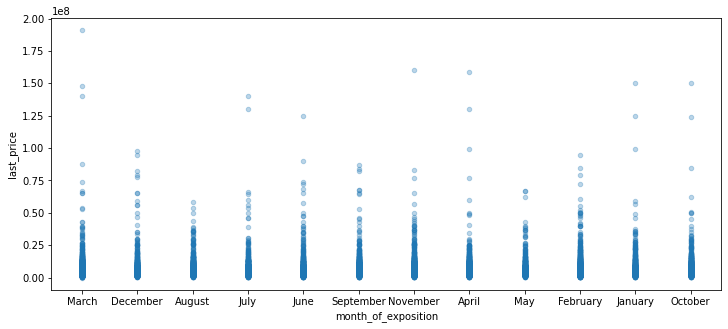

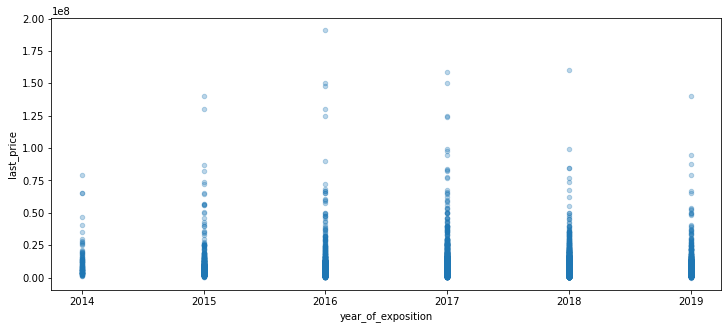

In [56]:
data.plot(x='day_of_week_exposition', y='last_price', kind='scatter', alpha=0.3, figsize=(12,5))
plt.show()
data.plot(x='month_of_exposition', y='last_price', kind='scatter', alpha=0.3, figsize=(12,5))
plt.show()
data.plot(x='year_of_exposition', y='last_price', kind='scatter', alpha=0.3, figsize=(12,5))
plt.show()

День недели, месяц и год публикации не влияют на стоимость. Разумеется на графиках присутствуют максимумы, но какой-либо конкретной тенденции не наблюдается.  

На формирование полной стоимости квартиры в основном влияют четыре фактора:
* Общая площадь
* Жилая площадь
* Количество комнат
* Этаж, на котором расположена квартира (первый, последний, другой)

Вклад остальных факторов незначителен или отсутствует.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [57]:
mean_square_meter_prices = (
    data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['count', 'mean'])
)
mean_square_meter_prices.columns = ['num_of_publications', 'mean_square_meter_price']

mean_square_meter_prices.sort_values(by='num_of_publications', ascending=False).head(10)

,num_of_publications,mean_square_meter_price
locality_name,,
Санкт-Петербург,14860,112687.204322
посёлок Мурино,529,85004.057807
Всеволожск,388,68571.339923
посёлок Парголово,323,90289.778019
Гатчина,305,68764.485115
деревня Кудрово,283,92297.218834
посёлок Шушары,250,80489.188360
Выборг,227,57972.726740
Кудрово,167,99989.421257


Исходя из вывода, можно сделать вывод, что наибольшее число обьявлений в наиболее крупных по площади населённых пунктах.

Выделим населённые пункты с наименьшей и наибольшой средней стоимостью одного квадратного метра.

In [58]:
mean_square_meter_prices_sort_by_price = mean_square_meter_prices.sort_values(by='mean_square_meter_price')

In [59]:
mean_square_meter_prices_sort_by_price.head()

,num_of_publications,mean_square_meter_price
locality_name,,
деревня Старополье,3,11206.22
посёлок станции Свирь,2,11481.48
деревня Вахнова Кара,1,11688.31
деревня Выскатка,2,12335.48
посёлок Совхозный,2,12629.13


In [60]:
mean_square_meter_prices_sort_by_price.tail()

,num_of_publications,mean_square_meter_price
locality_name,,
деревня Мистолово,11,98549.977273
Кудрово,167,99989.421257
Пушкин,70,100439.956714
Кронштадт,1,111470.590000
Санкт-Петербург,14860,112687.204322


Теперь выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.

In [61]:
spb_mean_price_by_km = (
    data.query('locality_name == "Санкт-Петербург"')
    .groupby('city_centers_nearest_km')
    .agg({'last_price': 'mean'})
)
spb_mean_price_by_km.columns = ['mean_last_price']
spb_mean_price_by_km.head()

,mean_last_price
city_centers_nearest_km,
0.0,4.244981e+07
1.0,1.623585e+07
2.0,1.512632e+07
3.0,1.055836e+07
4.0,1.145929e+07


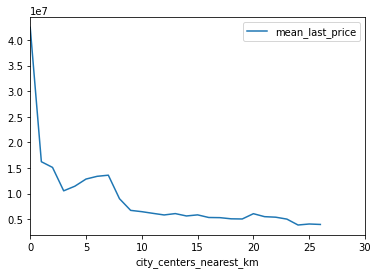

In [62]:
spb_mean_price_by_km.plot(xlim=(0,30))
plt.show()

Исходя из графика, получаем вполне логичное соотношение - расстояние до центра города обратно пропорциональна стоимости объекта. Разумеется, есть некоторые исключения, но их наличие вполне нормально.

На этом этапе мы провели исследовательский анализ данных.
* Построили гистограммы для следующих параметров: общая площадь, жилая площадь, площадь кухни, цена объекта, количество комнат, высота потолков, тип этажа квартиры, общее количество этажей в доме, расстояние до центра города в метрах, расстояние до ближайшего парка и устранили аномальные значения;
* Изучили, как быстро продавались квартиры. Пришли к выводу, что аномально быстрыми продажами можно считать продажи, совершённые менее чем за `44` дня, а аномально долгими те, что совершены более чем за `494` дня;
* Узнали, на формирование полной стоимости квартиры в основном влияют три фактора: общая площадь, жилая площадь, количество комнат;
* Посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделили населённые пункты с самой высокой и низкой стоимостью квадратного метра.
* Пришли к выводу, что квартиры в Санкт-Петербурге тем дешевле, чем больше они удалены от центра;

### Общий вывод

В этом проекте мы поработали с данными сервиса "Яндекс Недвижимость".<br>

Данные представляют собой архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.<br>

Нужно научиться определять рыночную стоимость объектов недвижимости. Необходимо провести исследовательский анализ данных, который поможет установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

Работа состояла из 4 этапов:
1. Знакомство с данными
2. Предобработка данных
3. Добавление новых столбцо
4. Исследовательский анализ

На первом этапе мы открыли файл с данными, построили гистограммы для каждого параметра, чтобы сразу увидеть возможные проблемы.

На втором этапе мы заполнили пропуски в столбцах, где это было возможно сделать, определили причины пропусков.

На третьем этапе добавили в таблицу несколько новых столбцов:
* `square_meter_price` - цена одного квадратного метра
* `day_of_week_exposition` - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
* `month_of_exposition` - месяц публикации объявления
* `year_of_exposition` - год публикации объявления
* `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»)
* `city_centers_nearest_km` - расстояние до центра города в километрах

На четвертом этапе мы сделали несколько важных выводов, которые и являлись основной целью работы:
* Изучили, как быстро продавались квартиры. Пришли к выводу, что аномально быстрыми продажами можно считать продажи, совершённые менее чем за 44 дней, а аномально долгими те, что совершены более чем за 494 дней;
* Узнали, на формирование полной стоимости квартиры в основном влияют четыре фактора: общая площадь, жилая площадь, количество комнат, этаж (первый, последний, другой);
* Посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделили населённые пункты с самой высокой и низкой стоимостью квадратного метра;
* Пришли к выводу, что квартиры в Санкт-Петербурге тем дешевле, чем больше они удалены от центра;

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод